In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Load CVDV library
from interface import CVDV

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled successfully!
Library loaded successfully!
Debug logs are written to: /home/luxi/cuda-cvdv/cuda.log
NOTE: Log file is cleared each time CVDV() is instantiated


In [3]:
# Simulation parameters
Q_N = 201          # Q function grid size
Q_MAX = 5.0        # Q function range
DV_LEVEL = 4
CV_LEVEL = 10      # CV register level (numQubits)

In [4]:
# Initialize three register system: [5, 5, CV_LEVEL]
# First two: small DV registers for joint measurement
# Last: CV register for Husimi-Q
sim = CVDV([DV_LEVEL, DV_LEVEL, CV_LEVEL])

# Initialize first two DV registers using formula:
N = 2**DV_LEVEL  # dimension = 2^5 = 32
dvInitCoeffs = np.zeros(N, dtype=complex)
for j in range(N):
    dvInitCoeffs[j] = np.exp(-(j - (N-1)/2)**2 * pi / (2*N))
# Normalize
dvInitCoeffs /= np.linalg.norm(dvInitCoeffs)
sim.setCoeffs(0, dvInitCoeffs)
sim.setCoeffs(1, dvInitCoeffs)

# Initialize last register with Fock superposition
sim.setFocks(2, [1/2, 0, 1j/sqrt(2), 0, 1/2])

# Build tensor product and upload to device
sim.initStateVector()

# Print system info
sim.info()

Number of registers: 3Initialized state with 3 registers, total size: 262144

Total state size: 262144 elements (0.004 GB in VRAM)
  Register 0: dim=16, qubits=4, dx=0.626657, x_bound=10.026513
  Register 1: dim=16, qubits=4, dx=0.626657, x_bound=10.026513
  Register 2: dim=1024, qubits=10, dx=0.078332, x_bound=80.212105


Computing joint measurement...
Size of joint Measurement: (16, 16)
Computing Husimi-Q...
Size of husimi_Q: (201, 201)
Integral of Q function over phase space: 0.999501781113386


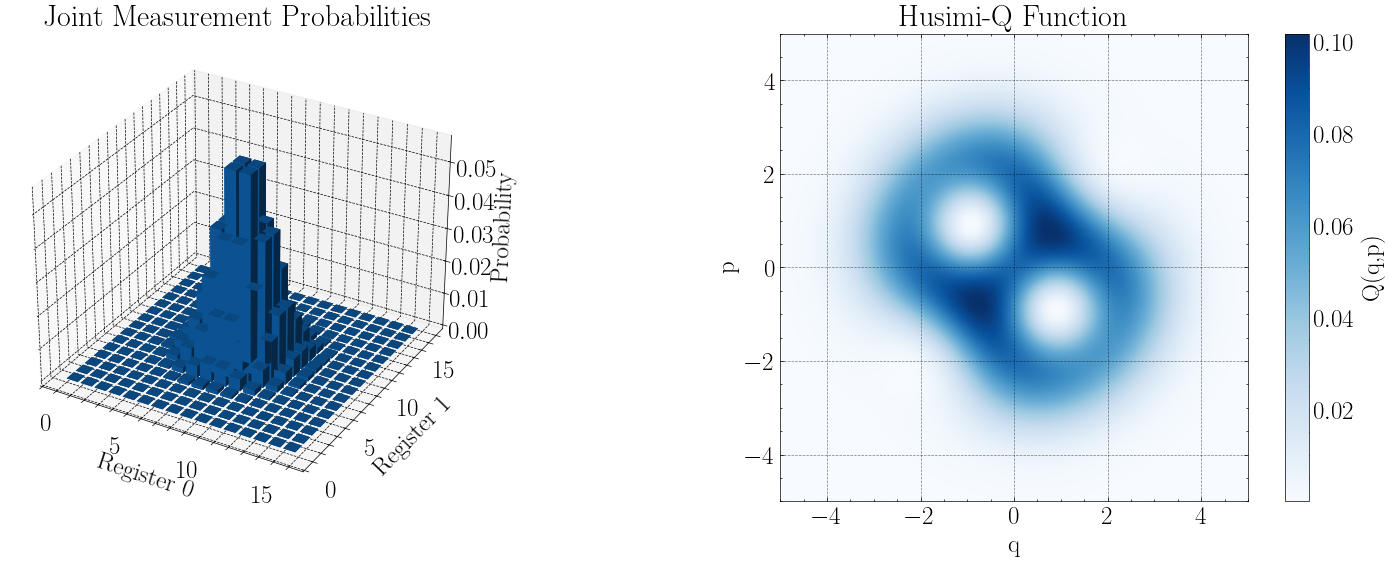

In [5]:
# Compute joint measurement of first two registers and Husimi-Q of last
print("Computing joint measurement...")
jointProbs = sim.jointMeasure(0, 1)
print("Size of joint Measurement:", jointProbs.shape)

print("Computing Husimi-Q...")
qFuncVals = sim.getHusimiQFullMode(2, qN=Q_N, qMax=Q_MAX, pMax=Q_MAX)
print("Size of husimi_Q:", qFuncVals.shape)

# Print Integral of Q function
integral_Q = qFuncVals.sum() * ( (2*Q_MAX)/(Q_N-1) )**2 / 2
print(f"Integral of Q function over phase space: {integral_Q}")

# Create figure with two subplots
fig = plt.figure(figsize=(16, 6))

# --- 3D Bar Plot for Joint Probabilities ---
ax1 = fig.add_subplot(121, projection='3d')

# Create coordinate arrays for the bars
N = 2**DV_LEVEL
x_pos = np.arange(N)
y_pos = np.arange(N)
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros_like(x_pos)

# Bar dimensions
dx = dy = 0.8
dz = jointProbs.flatten()

# Plot 3D bars
ax1.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True, cmap='viridis')
ax1.set_xlabel('Register 0')
ax1.set_ylabel('Register 1')
ax1.set_zlabel('Probability')
ax1.set_title('Joint Measurement Probabilities')

# --- Heatmap for Husimi-Q Function ---
ax2 = fig.add_subplot(122)

q_range = np.linspace(-Q_MAX, Q_MAX, Q_N)
p_range = np.linspace(-Q_MAX, Q_MAX, Q_N)

im = ax2.imshow(qFuncVals, extent=[-Q_MAX, Q_MAX, -Q_MAX, Q_MAX], 
                origin='lower', cmap='Blues', aspect='equal')
ax2.set_xlabel('q')
ax2.set_ylabel('p')
ax2.set_title('Husimi-Q Function')
plt.colorbar(im, ax=ax2, label='Q(q,p)')

plt.tight_layout()
plt.show()